In [53]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from statsmodels.tsa.statespace.sarimax import SARIMAX
pd.set_option('display.max_rows', 10)

In [54]:
df_hospital = pd.read_csv('../data/hospital_visits.csv')
df_hospital['Week'] = df_hospital.Week.map(str) + "-" + df_hospital.Year.map(str)
df_hospital = df_hospital[['Week', 'Total ILI']]
df_hospital.columns = ['Week', 'ILI']
df_hospital = df_hospital[28:256]
df_hospital = df_hospital.reset_index(drop=True)

df_twitter = pd.read_csv('../data/twitter-flu-data.csv', header=None)
df_twitter.columns = ['Year', 'Week', '1', '2', '3', '4', '5', '6', '7']
df_twitter['Week'] = df_twitter.Week.map(str) + "-" + df_twitter.Year.map(str)
df_twitter['Tweets'] = df_twitter[['1', '2', '3', '4', '5', '6', '7']].sum(axis=1)
df_twitter = df_twitter[['Week', 'Tweets']][27:-1]
df_twitter = df_twitter.reset_index(drop=True)

df_aus = pd.read_csv('../data/AUS_flu_virus_counts.csv')
df_aus['Week'] = df_aus.Week.map(str) + "-" + df_aus.Year.map(str)
df_aus = df_aus[['Week', 'ALL_INF']]
df_aus = df_aus[912:1168-27]
df_aus = df_aus.drop(977)
df_aus = df_aus.reset_index(drop=True)

df_google = pd.read_csv('../data/google_trends/flu-related queries/flu_trends.csv')
df_google['Week'] = df_google.Week.map(str) + "-" + df_google.Year.map(str)
df_google = df_google[['Week', 'Searches']]
df_google = df_google[21:250]
df_google = df_google.drop(86)
df_google.reset_index(drop=True)

,Week,Searches
0,15-2015,9
1,16-2015,9
2,17-2015,7
3,18-2015,6
4,19-2015,6
...,...,...
223,30-2019,4
224,31-2019,5
225,32-2019,5
226,33-2019,7


In [55]:
list_hospital = list(df_hospital['ILI'])
list_tweets = list(df_twitter['Tweets'])
list_aus = list(df_aus['ALL_INF'])
list_google = list(df_google['Searches'])

In [56]:
list_hospital_real = list_hospital[:-52]
list_tweets_real = list_tweets[:-52]
list_aus_real = list_aus[:-52]
list_google_real = list_google[:-52]

list_hospital_pred = list_hospital[-52:]
list_tweets_pred = list_tweets[-52:]
list_aus_pred = list_aus[-52:]
list_google_pred = list_google[-52:]

In [57]:
features = [list_tweets_real, list_aus_real, list_google_real]
pred = [list_tweets_pred, list_aus_pred, list_google_pred]

features = list(map(list, zip(*features)))
pred = list(map(list, zip(*pred)))

In [58]:
model = SARIMAX(endog=list_hospital_real, exog=features, order=(0, 1, 0), seasonal_order=(1, 1, 0, 52), enforce_stationarity=False, enforce_invertibility=False, trend='c')
model_fit = model.fit()

In [59]:
future = 52
predictions = model_fit.predict(len(list_hospital_real), len(list_hospital_real) + future - 1, exog=pred)
future_weeks = list(range(len(list_hospital_real), len(list_hospital_real) + future))

In [60]:
predictions_df = pd.DataFrame([future_weeks, predictions]).transpose()
predictions_df.columns = ['Week', 'Total ILI']
predictions_df = predictions_df.set_index('Week')

Text(0.5, 1.0, "Total ILI: 2015-2016 to 2018-2019 + predictions \n('flu' Google search term only)")

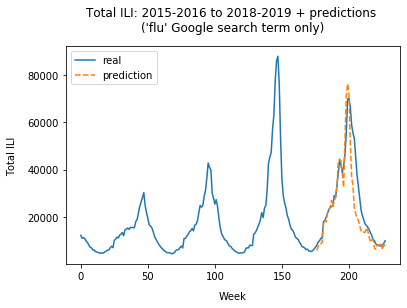

In [61]:
plt.plot(df_hospital['ILI'], label='real')
plt.plot(predictions_df, '--', label='prediction')
plt.legend()
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI: 2015-2016 to 2018-2019 + predictions \n('flu' Google search term only)", pad=15)

In [62]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 52)   Log Likelihood                -669.757
Date:                            Tue, 10 Dec 2019   AIC                           1351.514
Time:                                    22:54:01   BIC                           1365.090
Sample:                                         0   HQIC                          1356.912
                                            - 176                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -23.2342    542.211     -0.043      0.966   -1085.947    1039.479
x1           -14.8874      5.566     -2.675      0.007     -25.797      -3.978
x2             4.5104     10.979      0.411      0.681     -17.007      26.028
x3           352.5212     60.265      5.850      0.000     234.405     470.638
ar.S.L52       0.1511      0.203      0.745      0.456      -0.246       0.548
sigma2      9.142e+06   9.23e+05      9.909      0.000    7.33e+06     1.1e+07
===================================================================================
Ljung-Box (Q):                       24.17   Jarque-Bera (JB):               746.46
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -1.96
Prob(H) (two-sided):                  0.82   Kurtosis:                        18.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predicting a previous year

In [63]:
list_hospital_real = list_hospital[:-104]
list_tweets_real = list_tweets[:-104]
list_aus_real = list_aus[:-104]
list_google_real = list_google[:-104]

list_hospital_pred = list_hospital[-104:-52]
list_tweets_pred = list_tweets[-104:-52]
list_aus_pred = list_aus[-104:-52]
list_google_pred = list_google[-104:-52]

# Comment out these lines to only train on the data before where predictions will take place
list_hospital_real.extend(list_hospital[-52:])
list_tweets_real.extend(list_tweets[-52:])
list_aus_real.extend(list_aus[-52:])
list_google_real.extend(list_google[-52:])

In [64]:
features_transposed = [list_tweets_real, list_aus_real]
pred_transposed = [list_tweets_pred, list_aus_pred]

features = list(map(list, zip(*features_transposed)))
pred = list(map(list, zip(*pred_transposed)))

for feature_index in range(len(features)):
    features[feature_index].append(list_google_real[feature_index])

for pred_index in range(len(pred)):
    pred[pred_index].append(list_google_pred[pred_index])

In [65]:
model = SARIMAX(endog=list_hospital_real, exog=features, order=(1, 1, 0), seasonal_order=(1, 1, 0, 52), enforce_stationarity=False, enforce_invertibility=False, trend='c')
model_fit = model.fit()

In [66]:
future = 52
predictions = model_fit.predict(len(list_hospital_real), len(list_hospital_real) + future - 1, exog=pred)
future_weeks = list(range(len(list_hospital_real) - future, len(list_hospital_real)))

In [67]:
predictions_df = pd.DataFrame([future_weeks, predictions]).transpose()
predictions_df.columns = ['Week', 'Total ILI']
predictions_df = predictions_df.set_index('Week')

Text(0.5, 1.0, "Total ILI: 2015-2016 to 2018-2019 + predictions \n('flu' Google search term only)")

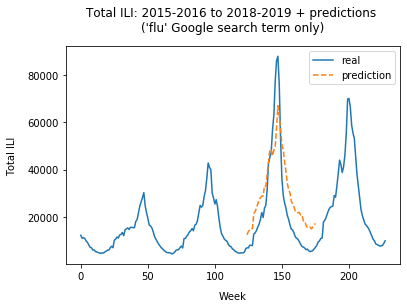

In [68]:
plt.plot(df_hospital['ILI'], label='real')
plt.plot(predictions_df, '--', label='prediction')
plt.legend()
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI: 2015-2016 to 2018-2019 + predictions \n('flu' Google search term only)", pad=15)

In [69]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 52)   Log Likelihood                -621.767
Date:                            Tue, 10 Dec 2019   AIC                           1257.534
Time:                                    22:55:29   BIC                           1273.273
Sample:                                         0   HQIC                          1263.786
                                            - 176                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     40.6789    210.048      0.194      0.846    -371.007     452.364
x1            -1.1442      2.562     -0.447      0.655      -6.166       3.878
x2           -18.3077      3.107     -5.892      0.000     -24.398     -12.218
x3            72.4973    206.050      0.352      0.725    -331.354     476.349
ar.L1          0.1839      0.136      1.352      0.176      -0.083       0.450
ar.S.L52      -0.0618      0.084     -0.732      0.464      -0.227       0.104
sigma2      2.933e+06   3.99e+05      7.343      0.000    2.15e+06    3.72e+06
===================================================================================
Ljung-Box (Q):                       20.14   Jarque-Bera (JB):                22.82
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.36   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""